**Project 2**

**Sequential Models in NLP**

---
**Sarcasm Detection**
Description
Past studies in Sarcasm Detection mostly make use of Twitter datasets collected using hashtag based
supervision but such datasets are noisy in terms of labels and language. Furthermore, many tweets are
replies to other tweets and detecting sarcasm in these requires the availability of contextual tweets.


In this hands-on project, the goal is to build a model to detect whether a sentence is sarcastic or not, using Bidirectional LSTMs.


**Dataset**

**News Headlines dataset for Sarcasm Detection**

The dataset is collected from two news websites, theonion.com and huffingtonpost.com
This new dataset has the following advantages over the existing Twitter datasets:


Since news headlines are written by professionals in a formal manner, there are no spelling mistakes and
informal usage. This reduces the sparsity and also increases the chance of finding pre-trained embeddings.
Furthermore, since the sole purpose of TheOnion is to publish sarcastic news, we get high-quality labels with
much less noise as compared to Twitter datasets.


Unlike tweets that reply to other tweets, the news headlines obtained are self-contained. This would help us in
teasing apart the real sarcastic elements.


**Content**

Each record consists of three attributes:
- is_sarcastic: 1 if the record is sarcastic otherwise 0
- headline: the headline of the news article
- article_link: link to the original news article. Useful in collecting supplementary data


**Reference**

https://github.com/rishabhmisra/News-Headlines-Dataset-For-Sarcasm-Detection

Download the dataset file

In [1]:
!wget https://raw.githubusercontent.com/rishabhmisra/News-Headlines-Dataset-For-Sarcasm-Detection/master/Sarcasm_Headlines_Dataset.json

--2020-08-21 14:24:39--  https://raw.githubusercontent.com/rishabhmisra/News-Headlines-Dataset-For-Sarcasm-Detection/master/Sarcasm_Headlines_Dataset.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6057046 (5.8M) [text/plain]
Saving to: ‘Sarcasm_Headlines_Dataset.json’

Sarcasm_Headlines_D 100%[===================>]   5.78M  14.5MB/s    in 0.4s    

2020-08-21 14:24:41 (14.5 MB/s) - ‘Sarcasm_Headlines_Dataset.json’ saved [6057046/6057046]



In [22]:
!wget https://github.com/sharmapratik88/AIML-Projects/blob/master/11_NLP_Sarcasm%20Detection/text_preprocess.py

--2020-08-21 14:50:43--  https://github.com/sharmapratik88/AIML-Projects/blob/master/11_NLP_Sarcasm%20Detection/text_preprocess.py
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘text_preprocess.py’

text_preprocess.py      [ <=>                ] 136.11K  --.-KB/s    in 0.04s   

2020-08-21 14:50:44 (3.16 MB/s) - ‘text_preprocess.py’ saved [139377]



In [40]:
!wget !wget http://nlp.stanford.edu/data/glove.6B.zip

--2020-08-21 15:32:38--  http://!wget/
Resolving !wget (!wget)... failed: Name or service not known.
wget: unable to resolve host address ‘!wget’
--2020-08-21 15:32:39--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2020-08-21 15:32:39--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2020-08-21 15:32:39--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64

In [24]:
# Import packages
import warnings; warnings.filterwarnings('ignore')
import pandas as pd, numpy as np, tensorflow as tf
import matplotlib.pyplot as plt, seaborn as sns
import matplotlib.style as style

import random, re
assert tf.__version__ >= '2.0'
%matplotlib inline

# Text preprocessing and stopwords
from text_preprocess import *

# Models
from tensorflow.keras.layers import Dense, LSTM, Embedding, Dropout, Flatten, Bidirectional, GlobalMaxPool1D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.initializers import Constant

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

# Set random state
random_state = 42
np.random.seed(random_state)
tf.random.set_seed(random_state)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


Load the dataset

In [5]:
data = pd.read_json('Sarcasm_Headlines_Dataset.json', lines = True)
print(f'Data has {data.shape[0]} rows and {data.shape[1]} columns. Here are the first five rows of the data...')
display(data.head())

Data has 28619 rows and 3 columns. Here are the first five rows of the data...


,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


Is Sarcastic count: 13634 i.e. 48.0%
Isn't Sarcastic count: 14985 i.e. 52.0%
Distributon of `is_sarcastic` label


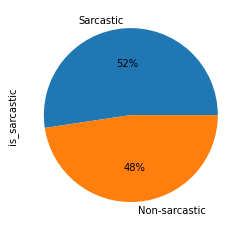

In [12]:

print(f'Is Sarcastic count: {data[data.is_sarcastic == 1].shape[0]} i.e. {round(data[data.is_sarcastic == 1].shape[0]/data.shape[0]*100, 0)}%')
print(f'Isn\'t Sarcastic count: {data[data.is_sarcastic == 0].shape[0]} i.e. {round(data[data.is_sarcastic == 0].shape[0]/data.shape[0]*100, 0)}%')

print('Distributon of `is_sarcastic` label');
data['is_sarcastic'].value_counts().plot(kind = 'pie', autopct = '%.0f%%', labels = ['Sarcastic', 'Non-sarcastic'], figsize = (6, 4))

In [13]:
hf = data[data['article_link'].str.contains('huffingtonpost.com')].shape[0]
op = data[data['article_link'].str.contains('theonion.com')].shape[0]

is_sarcastic_hf = data.loc[(data['article_link'].str.contains('huffingtonpost.com')) & (data['is_sarcastic'] == 1)].shape[0]
not_sarcastic_hf = data.loc[(data['article_link'].str.contains('huffingtonpost.com')) & (data['is_sarcastic'] == 0)].shape[0]

is_sarcastic_op = data.loc[(data['article_link'].str.contains('theonion.com')) & (data['is_sarcastic'] == 1)].shape[0]
not_sarcastic_op = data.loc[(data['article_link'].str.contains('theonion.com')) & (data['is_sarcastic'] == 0)].shape[0]

display(pd.DataFrame([[is_sarcastic_hf, is_sarcastic_op], [not_sarcastic_hf, not_sarcastic_op]], 
                     columns = ['huffingtonpost', 'theonion'], index = ['Sarcastic', 'Non-sarcastic']))

,huffingtonpost,theonion
Sarcastic,0,13634
Non-sarcastic,14985,1


In [20]:
#Dropping article_link column
data.drop('article_link', axis = 1, inplace = True)

Data Preprocessing

- Converting to lower case, avoid any capital cases
- Converting apostrophe to the standard lexicons
- Removing punctuations
- Lemmatization

In [26]:
print('Converting headlines to lower case')
data['cleaned_headline'] = data['headline'].apply(lambda x : x.lower())

print('Removing multiple spaces between words')
data['cleaned_headline'] = data['cleaned_headline'].apply(lambda x: re.sub(' +', ' ', x))


print('Removing punctuations')
data['cleaned_headline'] = data['cleaned_headline'].apply(lambda x: remove_punctuation(x))

print('Applying Lemmatizer')
data['cleaned_headline'] = data['cleaned_headline'].apply(lambda x: lem(x))


print('Replacing apostrophes to the standard lexicons')
data['cleaned_headline'] = data['cleaned_headline'].apply(lambda x : replace_words(x))



Converting headlines to lower case
Removing multiple spaces between words
Removing punctuations
Applying Lemmatizer
Replacing apostrophes to the standard lexicons


Get length of each sentence

In [29]:
print('Get the length of each line, find the maximum length and print the maximum length line'); 
# Get length of each line
data['line_length'] = data['cleaned_headline'].str.len()

print('Minimum line length: {}'.format(data['line_length'].min()))
print('Maximum line length: {}'.format(data['line_length'].max()))
print('Line with maximum length: {}'.format(data[data['line_length'] == data['line_length'].max()]['cleaned_headline'].values[0]))

Get the length of each line, find the maximum length and print the maximum length line
Minimum line length: 7
Maximum line length: 893
Line with maximum length: hot wheel ranked number one toy for rolling down ramp knocking over domino that send marble down a funnel dropping onto teetertotter that yank on string causing pulley system to raise wooden block propelling series of twine roller that unwind spring launching tennis ball across room inching tire down slope until it hit power switch activating table fan that blow toy ship with nail attached to it across kiddie pool popping water balloon that fill cup weighing down lever that force basketball down track nudging broomstick on axis to rotate allowing golf ball to roll into sideways coffee mug which tumble down row of hardcover book until handle catch hook attached to lever that cause wooden mallet to slam down on serving spoon catapulting small ball into cup attached by ribbon to lazy susan which spin until it push d battery down i

In [32]:
# Get length of each line
data['nb_words'] = data['cleaned_headline'].apply(lambda x: len(x.split(' ')))

print('Minimum number of words: {}'.format(data['nb_words'].min()))
print('Maximum number of words: {}'.format(data['nb_words'].max()))
print('Line with maximum number of words: {}'.format(data[data['nb_words'] == data['nb_words'].max()]['cleaned_headline'].values[0]))

Minimum number of words: 2
Maximum number of words: 151
Line with maximum number of words: hot wheel ranked number one toy for rolling down ramp knocking over domino that send marble down a funnel dropping onto teetertotter that yank on string causing pulley system to raise wooden block propelling series of twine roller that unwind spring launching tennis ball across room inching tire down slope until it hit power switch activating table fan that blow toy ship with nail attached to it across kiddie pool popping water balloon that fill cup weighing down lever that force basketball down track nudging broomstick on axis to rotate allowing golf ball to roll into sideways coffee mug which tumble down row of hardcover book until handle catch hook attached to lever that cause wooden mallet to slam down on serving spoon catapulting small ball into cup attached by ribbon to lazy susan which spin until it push d battery down incline plane tipping over salt shaker to season omelet


Word Cloud of Sarcastic and Non-sarcastic Headlines


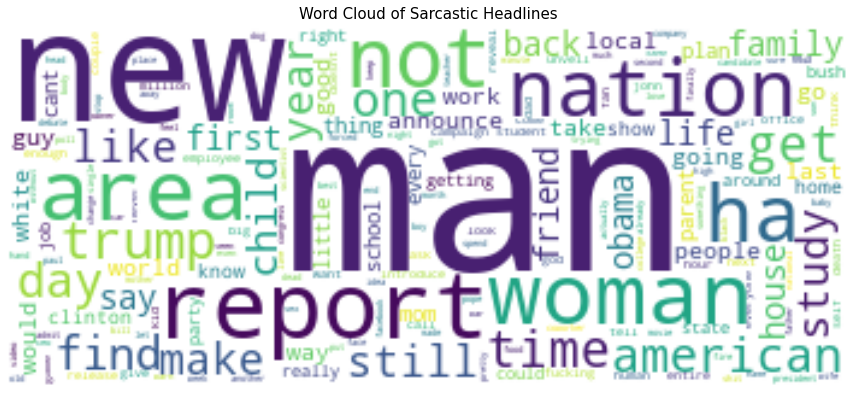

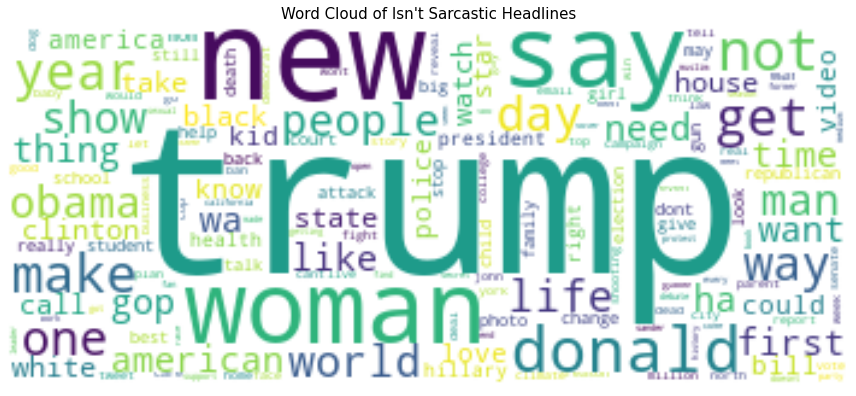

In [33]:
print('Word Cloud of Sarcastic and Non-sarcastic Headlines')
data['headline'] = data['headline'].fillna('')
sarcastic_headlines = ' '.join(data.loc[data['is_sarcastic'] == 1, 'cleaned_headline'])
plot_wordcloud(sarcastic_headlines, title = 'Word Cloud of Sarcastic Headlines')

non_sarcastic_headlines = ' '.join(data.loc[data['is_sarcastic'] == 0, 'cleaned_headline'])
plot_wordcloud(non_sarcastic_headlines, title = 'Word Cloud of Isn\'t Sarcastic Headlines')

In [35]:
print('Summary for number of words')
display(data['nb_words'].describe().round(0).astype(int)); 

print('99% quantilie: {}'.format(data['nb_words'].quantile(0.99)));

Summary for number of words


count    28619
mean        10
std          3
min          2
25%          8
50%         10
75%         12
max        151
Name: nb_words, dtype: int64

99% quantilie: 19.0


Define Parameters

In [36]:
max_features = 10000
maxlen = data['nb_words'].max()
embedding_size = 200

Applying Keras Tokenizer

In [37]:
tokenizer = Tokenizer(num_words = max_features)
tokenizer.fit_on_texts(list(data['cleaned_headline']))

In [38]:
X = tokenizer.texts_to_sequences(data['cleaned_headline'])
X = pad_sequences(X, maxlen = maxlen)
y = np.asarray(data['is_sarcastic'])

print(f'Number of Samples: {len(X)}')
print(f'Number of Labels: {len(y)}')
print(f'\nFirst headline:\n{X[0]}\n\nLabel of the first headline: {y[0]}')

Number of Samples: 28619
Number of Labels: 28619

First headline:
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0  328 2981 5807 2302    2  700 1104]

Label of the first headline: 1


Get the Vocabulary size

In [39]:
# Reserve padding (indexed zero)
w2i = tokenizer.word_index
vocab_size = len(w2i) + 1
print(f'Number of unique tokens: {vocab_size}')

Number of unique tokens: 26061


Word Embedding

Get Glove Word Embeddings

In [41]:
glove_file = 'glove.6B.zip'

In [42]:
#Extract Glove embedding zip file
from zipfile import ZipFile
with ZipFile(glove_file, 'r') as z:
  z.extractall()

Get word embeddings using embedding file

In [43]:
EMBEDDING_FILE = './glove.6B.200d.txt'

embeddings = {}
for o in open(EMBEDDING_FILE):
    word = o.split(' ')[0]
    embd = o.split(' ')[1:]
    embd = np.asarray(embd, dtype = 'float32')
    embeddings[word] = embd

Create a weight matrix

In [44]:
# Getting the minimum number of words
num_words = min(max_features, vocab_size) + 1

embedding_matrix = np.zeros((num_words, embedding_size))
for word, i in tokenizer.word_index.items():
    if i > max_features: continue
    embedding_vector = embeddings.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

len(embeddings.values())

400000

Create and Compile Model
- Split the data into train, valid and test set so that it's easy to compare and evaluate
- Use Sequential model instance
- Add Embedding layer
- Bidirectional(LSTM) layer
- GlobalMaxPool1D layer
- Dense, dropout layers
- Add a final dense layer with sigmoid activation for binary classification

In [45]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = random_state, shuffle = True)

print('---'*20, f'\nNumber of rows in training dataset: {x_train.shape[0]}')
print(f'Number of columns in training dataset: {x_train.shape[1]}')
print(f'Number of unique words in training dataset: {len(np.unique(np.hstack(x_train)))}')

print('---'*20, f'\nNumber of rows in test dataset: {x_test.shape[0]}')
print(f'Number of columns in test dataset: {x_test.shape[1]}')
print(f'Number of unique words in test dataset: {len(np.unique(np.hstack(x_test)))}')

------------------------------------------------------------ 
Number of rows in training dataset: 22895
Number of columns in training dataset: 151
Number of unique words in training dataset: 9977
------------------------------------------------------------ 
Number of rows in test dataset: 5724
Number of columns in test dataset: 151
Number of unique words in test dataset: 7657


In [46]:
model = Sequential()
model.add(Embedding(num_words, embedding_size, embeddings_initializer = Constant(embedding_matrix), input_length = maxlen, trainable = False))
model.add(Bidirectional(LSTM(128, return_sequences = True)))
model.add(GlobalMaxPool1D())
model.add(Dropout(0.5, input_shape = (256,)))
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.5, input_shape = (128,)))
model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.5, input_shape = (64,)))
model.add(Dense(1, activation = 'sigmoid'))

model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

# Adding callbacks
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 10)  
mc = ModelCheckpoint('sarcasm_detector.h5', monitor = 'val_loss', mode = 'min', save_best_only = True, verbose = 1)
lr_r = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, patience = 5),
logdir = 'log'; tb = TensorBoard(logdir, histogram_freq = 1)
callbacks = [es, mc, lr_r, tb]

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 151, 200)          2000200   
_________________________________________________________________
bidirectional (Bidirectional (None, 151, 256)          336896    
_________________________________________________________________
global_max_pooling1d (Global (None, 256)               0         
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               32896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8

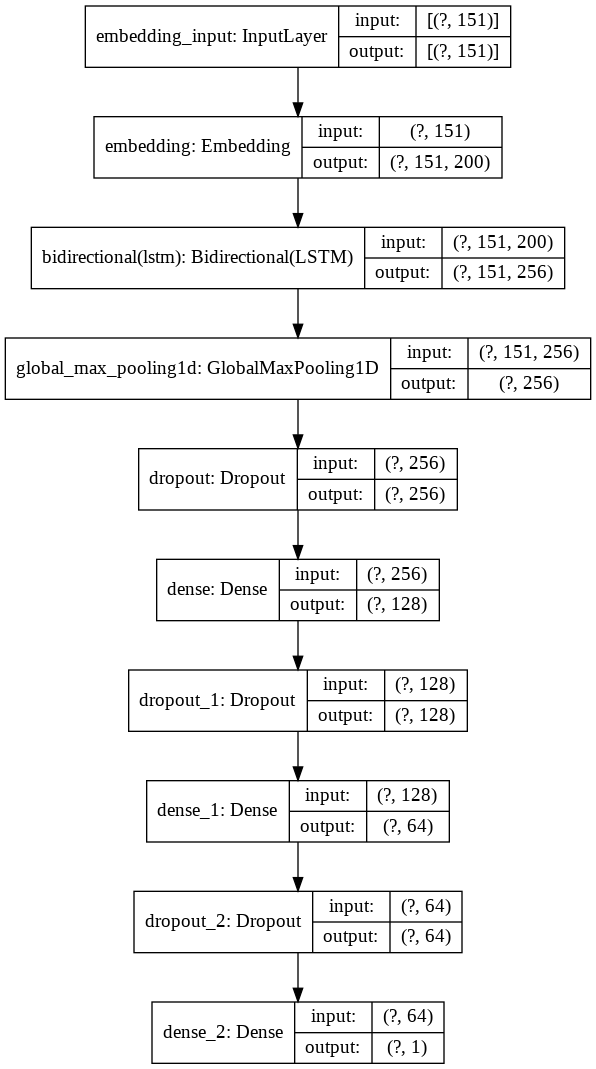

In [47]:
tf.keras.utils.plot_model(model, show_shapes = True)

Fitting model
- Setting batch_size = 100 and epoch = 2

In [52]:
batch_size = 200
epochs = 8

h = model.fit(x_train, y_train, epochs = epochs, validation_split = 0.2, batch_size = batch_size, verbose = 2, callbacks = callbacks)

Epoch 1/8

Epoch 00001: val_loss improved from 0.33892 to 0.33878, saving model to sarcasm_detector.h5
92/92 - 121s - loss: 0.2366 - accuracy: 0.9051 - val_loss: 0.3388 - val_accuracy: 0.8611
Epoch 2/8

Epoch 00002: val_loss did not improve from 0.33878
92/92 - 119s - loss: 0.2045 - accuracy: 0.9183 - val_loss: 0.3479 - val_accuracy: 0.8576
Epoch 3/8

Epoch 00003: val_loss did not improve from 0.33878
92/92 - 119s - loss: 0.1971 - accuracy: 0.9206 - val_loss: 0.3717 - val_accuracy: 0.8611
Epoch 4/8

Epoch 00004: val_loss did not improve from 0.33878
92/92 - 118s - loss: 0.1802 - accuracy: 0.9290 - val_loss: 0.3731 - val_accuracy: 0.8589
Epoch 5/8

Epoch 00005: val_loss did not improve from 0.33878
92/92 - 119s - loss: 0.1641 - accuracy: 0.9355 - val_loss: 0.3979 - val_accuracy: 0.8602
Epoch 6/8

Epoch 00006: val_loss did not improve from 0.33878
92/92 - 121s - loss: 0.1417 - accuracy: 0.9440 - val_loss: 0.4337 - val_accuracy: 0.8513
Epoch 7/8

Epoch 00007: val_loss did not improve from

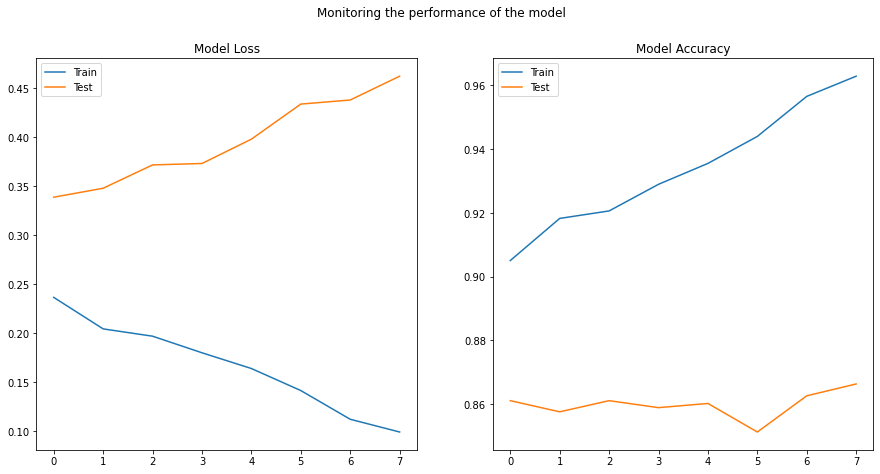

In [55]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 7.2))
f.suptitle('Monitoring the performance of the model')

ax1.plot(h.history['loss'], label = 'Train')
ax1.plot(h.history['val_loss'], label = 'Test')
ax1.set_title('Model Loss')
ax1.legend(['Train', 'Test'])

ax2.plot(h.history['accuracy'], label = 'Train')
ax2.plot(h.history['val_accuracy'], label = 'Test')
ax2.set_title('Model Accuracy')
ax2.legend(['Train', 'Test'])

plt.show()

In [56]:
# Evaluate the model
loss, accuracy = model.evaluate(x_test, y_test, verbose = 0)
print('Overall Accuracy: {}'.format(round(accuracy * 100, 0)))

Overall Accuracy: 86.0


In [57]:
y_pred = (model.predict(x_test) > 0.5).astype('int32')
print(f'Classification Report:\n{classification_report(y_pred, y_test)}')

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.87      0.87      2964
           1       0.86      0.85      0.86      2760

    accuracy                           0.86      5724
   macro avg       0.86      0.86      0.86      5724
weighted avg       0.86      0.86      0.86      5724



Confusion Matrix


,Non-sarcastic,Sarcastic
Non-sarcastic,2589,406
Sarcastic,375,2354


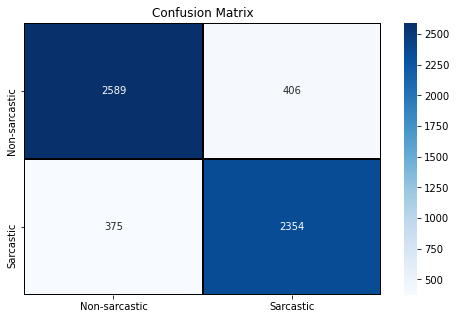

In [58]:
print('Confusion Matrix')
cm = confusion_matrix(y_test, y_pred)
cm = pd.DataFrame(cm , index = ['Non-sarcastic', 'Sarcastic'] , columns = ['Non-sarcastic','Sarcastic'])
display(cm); 
plt.figure(figsize = (8, 5))
_ = sns.heatmap(cm, cmap= 'Blues', linecolor = 'black' , linewidth = 1 , annot = True, 
            fmt = '' , xticklabels = ['Non-sarcastic', 'Sarcastic'], 
            yticklabels = ['Non-sarcastic', 'Sarcastic']).set_title('Confusion Matrix')

In [59]:
print('Evaluate model on sample sarcastic lines'); print('--'*30)
statements = ['Are you always so stupid or is today a special ocassion?', #Sarcasm
              'I feel so miserable without you, it\'s almost like having you here.', #Sarcasm
              'If you find me offensive. Then I suggest you quit finding me.', #Sarcasm
              'If I wanted to kill myself I would climb your ego and jump to your IQ.', #Sarcasm
              'Amphibious pitcher makes debut', #Sarcasm
              'It\'s okay if you don\'t like me. Not everyone has good taste.' #Sarcasm
              ]

for statement in statements:
  statement = statement.lower()
  statement = replace_words(statement)
  statement = remove_punctuation(statement)
  statement = lem(statement)
  statement = re.sub(' +', ' ', statement)

  headline = tokenizer.texts_to_sequences(statement)
  headline = pad_sequences(headline, maxlen = maxlen, dtype = 'int32', value = 0)

  sentiment = (model.predict(headline) > 0.5).astype('int32')
  if(np.argmax(sentiment) == 0):
      print(f'`{statement}` is a Non-sarcastic statement.')
  elif (np.argmax(sentiment) == 1):
      print(f'`{statement}` is a Sarcastic statement.')

Evaluate model on sample sarcastic lines
------------------------------------------------------------
`are you always so stupid or is today a special ocassion` is a Sarcastic statement.
`i feel so miserable without you it is almost like having you here` is a Sarcastic statement.
`amphibious pitcher make debut` is a Sarcastic statement.
`it is okay if you do not like me not everyone ha good taste` is a Sarcastic statement.


**Conclusion**

- We used data pre-processing techniques to clean headlines, such as:
  - Converting to lower case
  - Converting to standard lexicons such as it's to it is
  - Remove punctuations
  - Lemmatize
  - Remove multiple spaces
- Some of the observation:
  - 44% of the data have sarcastic labels whereas 56% don't.
  - Suprising! There are no headlines from HuffPost that are sarcastic whereas all but one from The Onion are sarcastic.
  - Based on some random headlines seen above, it appears that the data is mostly lower-cased. Pre-processing such as removing punctuations and lemmatization can be used.
  - There are digits in the headlines for e.g. 3 things i needed to hear when i weighed 300 pounds where removing the digits wouldn't help.
  - 83% of data where length of sentence (headlines) > 100 are sarcastic headlines.
- Used Glove embedding layer with Bidirectional LSTM layer. Model architecture was also plotted. Also saw how we can use tensorboard to visualize the metrics such as loss and accuracy.
- Created a separate training and test sets; while fitting the model kept aside a 0.2 for validation;
- Model achieved 86% accuracy on the test set; classification report and confusion matrix were also printed.
- Model was also evaluated on some sample sarcastic statements and did well in identifying all them as sarcasm.